In [3]:
# General utilities
import requests
import yaml

# geospatial
import shapely 
import geopandas as gpd
import osmnx as ox
import pandana as pa
from shapely.geometry import Point, MultiPoint, LineString, Polygon, MultiPolygon
from descartes import PolygonPatch
from mpl_toolkits.basemap import Basemap

# data transformation
import numpy as np
import pandas as pd
import networkx as nx

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Extra nifty methods
from collections import Counter

# Open the API keys stored in a YAML file
with open("../utils/api_keys.yaml", 'r') as stream:
    data_loaded = yaml.safe_load(stream)

## Routes as a building block

While routes are technically a foundation topic, I deliberately left them to this 'Applications' section. The reason is that routes (and routing) can be used in several sophisticated and useful ways. The key applications we'll work on _aggregating_ routes to generate insight. 

| Topic | Example| Connection to routes |
|:-----:|:------:| :------------------: |
|Connectivity networks between amenities|<img src="../assets/z-connectivity-network.png" alt="drawing" width="300"/>| Aggregating routes to edges| 
|Amenity catchment analysis |<img src="../assets/park-catchment-polygons.png" alt="drawing" width="300"/>| Aggregating routes to nodes| 
|Accessibility to amenities| <img src="../assets/closer-to-z-or-bp.png" alt="drawing" width="300"/>| Aggregating routes to nodes| 
|Flows to destinations (including amenities)| <img src="../assets/flows.png" alt="drawing" width="300"/>| Aggregating routes to edges |

## Utilities
First we need import some utilities from the foundation section that we'll be re-using. In a less 'hack-y' analysis, we'd be refactoring these functions into utility scripts. 

In [4]:
## ADJUSTMENT OF A PACKAGE FUNCTION
def get_edge_colors_by_attr(G, attr, num_bins=5, cmap='viridis', start=0, stop=1, na_color='none'):
    """
    Get a list of edge colors by binning some continuous-variable attribute into
    quantiles.
    Parameters
    ----------
    G : networkx multidigraph
    attr : string
        the name of the continuous-variable attribute
    num_bins : int
        how many quantiles
    cmap : string
        name of a colormap
    start : float
        where to start in the colorspace
    stop : float
        where to end in the colorspace
    na_color : string
        what color to assign nodes with null attribute values
    Returns
    -------
    list
    """
    if num_bins is None:
        num_bins=len(G.edges())
    bin_labels = range(num_bins)
    attr_values = pd.Series([data[attr] for u, v, key, data in G.edges(keys=True, data=True)])
    cats = pd.qcut(x=attr_values.rank(method='first'), q=num_bins, labels=bin_labels)
    colors = ox.get_colors(num_bins, cmap, start, stop)
    edge_colors = [colors[int(cat)] if pd.notnull(cat) else na_color for cat in cats]
    return edge_colors


## CUSTOM FUNCTIONS
def try_shortest_path(origin, destination, G):
    """
    Function that gets shortest path with Networkx if it exists. 
    Returns [0] if there is no shortest path instead of an error. 
    Uses Dkijstra's algorithm by default. None others accepted at present
    Parameters
    ----------
    origin:
    destination:
    G:
    Returns
    -------
    goodpath
    """  
    try:
        goodpath = nx.shortest_path(G, origin, destination)
        return(goodpath)
    except:
        return([0])


def path_to_edge(path, G):
    """
    Function that converts a list of nodes to edges 
    Parameters
    ----------
    G: graph
    path: list of nodes in route
    Returns
    -------
    edges: list of (start_node, end_node) tuples
    """
    edges = list(zip(path[:-1], path[1:]))
    return(edges)

## Get Data
Like the previous notebook, we need to load in a bunch of datasets
- Driving street network for Wellington
- Walking street network for Wellington
- WCC playgrounds

In [5]:
# Define bounding box (W, S, E, N) for the area of Wellington we're interested in
# Copied from http://boundingbox.klokantech.com/
general_bbox = [174.5813,-41.4552,175.0722,-41.1527]

# Separate out the bounding box list into 4 vertices. 
south = general_bbox[1]
west = general_bbox[0]
north = general_bbox[3]
east = general_bbox[2]

# Set OSM bounding box
osm_bbox = [south, west, north, east]

# Open the API keys stored in a YAML file
with open("../utils/api_keys.yaml", 'r') as stream:
    data_loaded = yaml.safe_load(stream)

# Get Google Elevation API key
google_elevation_api_key = data_loaded['google_elevation_api_key'][0]

In [6]:
# Get driving network and split into edge and node dataframes
G_drive = ox.graph_from_bbox(north, south, east, west, network_type='drive')
G_drive_nodes_df, G_drive_edges_df = ox.graph_to_gdfs(G_drive)

In [7]:
# Get walking network and split into edge and node dataframes
G_walk = ox.graph_from_bbox(north, south, east, west, network_type='walk')
G_walk_nodes_df, G_walk_edges_df = ox.graph_to_gdfs(G_walk)

In [8]:
# Read geospatial data of playgrounds
wcc_playgrounds = gpd.read_file('zip://../data/WCC_Playgrounds.zip')

## Simple routes
The simplest route uses the Networkx get_shortest_path method. The input parameters are the start and end nodes. Osmnx has a useful method that allows us to find the nearest network node to a geolocation. Here, we'll find the shortest route from a nice bakery, Arobake, in one of the central Wellington suburbs to a playground up the hill. 

I've deliberately routed to a  playground up the hill rather than one on the flat because a continuation of finding a route is to look at an elevation profile. And it's more interesting to look at a profile with some elevation changes! 

We have previously downloaded the whole street network for the Wellington bounding box but here we'll download a small subset of the network around the Central Park Play Area - to better visualise the details of the routes. 

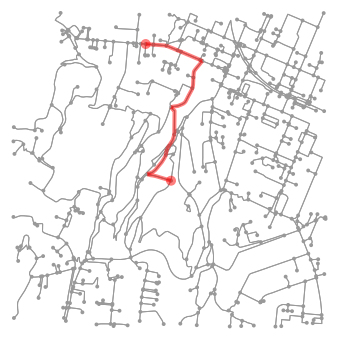

In [9]:
# Get location of Central Park Play Area
cp = (wcc_playgrounds
      .query('playground == "Central Park Play Area"')
      .reset_index())['geometry']
destination = (cp.y[0], cp.x[0])

# Get a small radious of street network around Central Park Play Area
G = ox.graph_from_point(destination, distance=600, 
                        network_type='walk', clean_periphery=False)

# Select origin and destination nodes
origin = (-41.2954888, 174.7671616)
destination = destination
origin_node = ox.get_nearest_node(G, origin)
destination_node = ox.get_nearest_node(G, destination)

# Get Route
route = nx.shortest_path(G, origin_node, destination_node)
fig, ax = ox.plot_graph_route(G, route)

### Enrich street network with elevation
As in the foundation section, we'll enrich the network with elevation values for nodes and edges. 

In [10]:
# Get Google Elevation API key
google_elevation_api_key = data_loaded['google_elevation_api_key'][0]

# Add elevation values for the nodes in the OSMNX graph
G_elev = ox.add_node_elevations(G, api_key=google_elevation_api_key)

# Generate an edge grade (inclination) with the elevations at the nodes
G_elev = ox.add_edge_grades(G_elev)

# Split the graph into node and edge dataframes 
G_elev_nodes_df, G_elev_edges_df = ox.graph_to_gdfs(G_elev)

### Draw elevation profile of route
To get the elevation profile, we need to: convert the list of nodes in the route to a dataframe with elevation information. We'll get elevation information for both the nodes and edges though only the node elevation will be used in creating the profile. 

To get additional information about the route, we need to:
- convert the list of nodes to edges and transformt into a dataframe
- join in edge and node attributes dataframes by node ID

In [11]:
# Convert route to edge coordinates
p = path_to_edge(route, G_elev)
# Get dataframe of route. Using (u,v) coordinate names like osmnx
df_route = pd.DataFrame({"u": [i[0] for i in p], "v": [i[1] for i in p]})
df_route.head()

,u,v
0,2657057850,277837013
1,277837013,2577629098
2,2577629098,2608606646
3,2608606646,2623860064
4,2623860064,279093518


In [12]:
# Join to edges dataframe to get edge attributes
df_route = pd.merge(df_route, G_elev_edges_df)
# Create cumulative route length column
df_route['cumulative_length'] = np.cumsum(df_route['length'])
# Get elevation of node in route from Graph
df_route['node_elevation'] = [G_elev_nodes_df[G_elev_nodes_df['osmid'] == x]
                              ['elevation'][x] for x in df_route['u']]

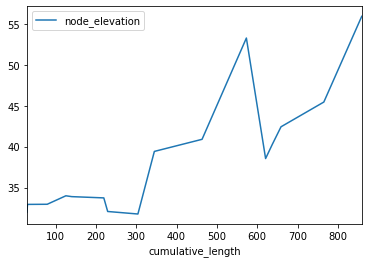

In [13]:
df_route.reset_index().plot('cumulative_length', 'node_elevation')

### Compare route with other algorithms

The elevation profile gives a clear picture of the ups and downs in the shortest route picked by the algorithm. But how does this compare with other routing algorithms? Especially those used by map services. 

| [Google Maps](https://www.google.com/maps/dir/Arobake+83+Aro+St,+Aro+Valley,+Wellington+6021/Central+Park+Play+Area+Brooklyn+Road,+Brooklyn,+Wellington/@-41.2973742,174.7668748,17z/data=!3m1!4b1!4m14!4m13!1m5!1m1!1s0x6d38b02430d702d9:0xfbcdeed81f6207ea!2m2!1d174.7671644!2d-41.2955197!1m5!1m1!1s0x6d38b0217d69413d:0xf057a9940fff37a8!2m2!1d174.768169!2d-41.299557!3e2) | [Graph Hopper](https://graphhopper.com/maps/?point=Arobake%2C%206040%2C%20Wellington%2C%20New%20Zealand&point=Central%20Park%20Play%20Area%2C%20Brooklyn&locale=en-GB&vehicle=foot&weighting=fastest&elevation=true&use_miles=false&layer=Omniscale)| 
| :---------: | :----------: | 
| ![](../assets/arobake-to-central-park.png)| ![](../assets/arobake-to-central-park-graphopper.png)|

- Graph Hopper is closer to the route picked out by Networkx since both use OpenStreetMap data. However, notice the difference in the elevation values. 
- Google maps elevation values match our data better because, duh, we enriched OpenStreetMap with elevations from Google Elevation API. 
- So, the Networkx route is a frankenroute - agreeing with both and neither Google Maps or Graph Hopper. 

### Discussion
- What other metrics can be used to find the shortest routes?

### Homework exercise

- For a deeper look into the difference between Networkx and Graph Hopper, you can [use the Graph Hopper Routing API](https://docs.graphhopper.com/#operation/getRoute). Again, you'll need to register for an API key. You can tune the information you need using the API query parameters. A screenshot of an old query of mine shows the returned route with street name and edge length information. 

![](../assets/graph-hopper-api-result.png)


## Routes to connectivity networks

The first example of extending routes is by aggregating the shortest route distances into new nodes to connect entities. These new networks are abstractions that have both retained the most minimally useful spatial information. 

Pairwise routes between entities, like amenities, can be used to understand spatial clustering. The following example of Z and BP fuel stations in Wellington showcases interesting properties of fuel station distribution and coverage. 
- The Z Wellington City component is very tightly connected for the central and southern suburbs while BP stations are better connected in the northern suburbs.
- The BP Lower Hutt component is much better connected than Z.

| Z | BP|
| :--------: | :---------: |
|<img src="../assets/z-connectivity-network.png" alt="drawing" width="300"/>|<img src="../assets/bp-connectivity-network.png" alt="drawing" width="300"/>|

### Recipe for creating connectivity networks

- Get amenity of interest in region
    - Use Overpass query
- Calculate the best route between every amenity pair
- Connect amenities within a distance threshold
    - Connect nearest neighbour with an edge
    - Edge weight equals the pairwise distance
    - Only keep edges below a certain radial distance (e.g. 10 km)
- Abstract to a network without geolocation - though preserving node geolocation would be useful if the area is unfamiliar! 

![](../assets/constructing_spatial_network.png)

### Discussion
- Can you think of any other amenities that would merit this abstraction?
- What could we learn with these networks?

## Catchment analysis
For anyone working in planning (retail or urban), catchment analysis is a common tool. Catchment analysis aggregates route distances to the _nodes_ while in the previous example, route distances were aggregated to new _edges_. 

Anyone who's visited London will remember the 5 and 15 minute walk catchment circles from the board location. Catchments also go by the name 'isochrones'. A technical defintion of an isochrone is:
> a line drawn on a map connecting points at which something occurs or arrives at the same time

### Playground catchment
[Wellington City Council uses catchments](https://wellington.govt.nz/~/media/your-council/plans-policies-and-bylaws/plans-and-policies/a-to-z/play-spaces/play-spaces-policy.pdf?la=en) to analyse the coverage of council playgrounds in the city. They use single catchment polygons that capture streets within 600 m of a playground. In this section on catchments and the following on accessibility, we'll go into _more_ detail than the single public facing map provided by the council. 

![](../assets/council-playground-catchments.png)

Catchments / isochrones are usually pre-defined for a given context. The 600 m catchment of a council playground is defined by an underlying travel time of 10 minutes. The council aims to provide a playground within 10 minutes of walking for a significant portion of the city. Catchment areas for retail like supermarkets or malls will usually consider driving isochrones that will be formulated according to the typical driving behaviours in the are. 

Here, we'll calculate and draw the catchment areas for Central Park Play Area. Unlike the connectivity network calculations in the previous section, this calculation is much faster as it uses a clever method in the Networkx toolkit: [an ego graph](https://networkx.github.io/documentation/stable/reference/generators.html#module-networkx.generators.ego).

The ego graph is a subset of the whole network centered around the 'ego' / focal point. Here, the ego is a point representing the Central Park Play Area. The ego_graph algorithm can subset the network according to specific distances - thus calculating implicit routes between the playground and the nodes in the nearby street network. 

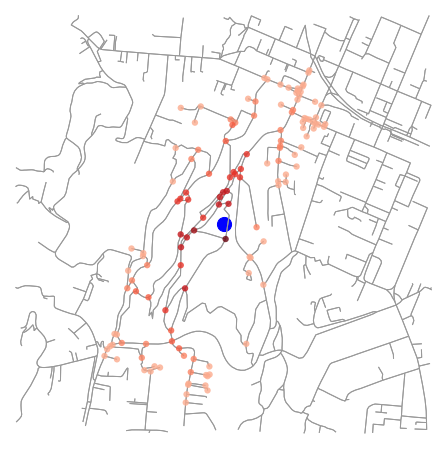

In [14]:
# Set the isochrone thresholds
trip_distances = [0, 100, 200, 300, 400, 500, 600]

# Generate some colours for the isochrones
iso_colors = ox.get_colors(n=len(trip_distances), cmap='Reds', start=0.3, return_hex=True)

# Subset egographs for each of the isochrones 
# Set colours of nodes by the isochrone
# Reverse the isochrones so that darker is closer
node_colors = {}
for trip_distance, color in zip(sorted(trip_distances, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, destination_node, radius=trip_distance, distance='length')
    for node in subgraph.nodes():
        node_colors[node] = color

# Create node size and node colour variables for nodes within the isochrones        
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [40 if node in node_colors else 0 for node in G.nodes()]

# Plot a basic catchment graph
fig, ax = ox.plot_graph(G, fig_height=8, node_color=nc, node_size=ns,
                        node_alpha=0.8, node_zorder=2, show=False, close=False)
# Plot Central Park Play Area
ax.scatter(destination[1], destination[0], s=200, c='b')


Coloured points are not particularly informative. We need to convert the node distance information into an area. [Convex hulls](https://en.wikipedia.org/wiki/Convex_hull) are a useful technique for converting points into a minimally enclosing entity - usually a polygon. Once we have polygons, we have isochrones! Add a bit of complicated code for a colourbar and we have a useful catchment plot for a council playground. 

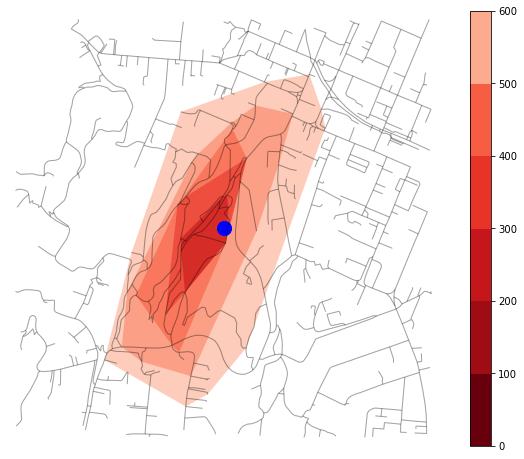

In [15]:
isochrone_polys = []

# Subset egographs for each of the isochrones 
# Reverse the isochrones so that darker is closer
# Set colours of nodes by the isochrone
# Combine all the nodes within the isochrone into a polygon
for trip_distance in sorted(trip_distances, reverse=True):
    subgraph = nx.ego_graph(G, destination_node, radius=trip_distance, distance='length')
    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)
    
# Plot the network 
fig, ax = ox.plot_graph(G, fig_height=8, show=False, close=False, edge_color='k',
                        edge_alpha=0.2, node_color='none')
# Plot Central Park Play Area
ax.scatter(destination[1], destination[0], s=200, c='b')

# Add polygon patches for each isochrone
# Colours are the same as the previous plot
# Some of the bounding polygons have not created polygons: don't plot these
for polygon, fc in zip(isochrone_polys, iso_colors):
    if polygon.geom_type == 'Polygon':
        patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
        ax.add_patch(patch)
    
# Create colourbar: different to before because we have a different colourmap
cmap = mpl.colors.ListedColormap(list(reversed(iso_colors)))
norm = mpl.colors.BoundaryNorm(trip_distances, cmap.N)

# Add colourbar to axis
cax, _ = mpl.colorbar.make_axes(ax, location='right')
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm)

The catchment area of Central Park Play Area is an oblong due to the geography of the area: Central Park on the east side and Tanera Park on the west. The denser residential areas are at the bottom of the hill in Aro Valley, and at the top of the hill in Brooklyn. 

## Accessibility analysis
The [pandana](http://udst.github.io/pandana/) package, while not maintained regularly, is still a powerful open source tool to calculate accessibility. In this workshop, we'll use a very quantitative definition of accessibility: shortest distance to nearest points of interest (here, council playgrounds). 

The steps for an accessibility analysis are:
- Create a pandana network
    - a similar yet _different_ to the osmnx / networkx network used so far
- Set points of interest (POIs)
- Calculate accessibility: distance to nearest POIs 
    - from any node in the pandana network
    - calculation can be limited to within some threshold
    - nodes further than the threshold are ignored
    - calculation can get N nearest POIs
- Plot accessibility to nearest POI as a heatmap
- Continue analysis with calculated accessibilities

### Create a pandana network
- pandana.network.Network
    - node_x, node_y
    - edge_from, edge_to
    - edge_weights
    - twoway=True
- Create the transportation network in the city. Typical data would be:
    - distance based from OpenStreetMap
    - travel time from GTFS transit data

In [16]:
# Create a Pandana network
flat_distance_network = pa.Network(G_walk_nodes_df['x'], G_walk_nodes_df['y'],
                                   G_walk_edges_df['u'], G_walk_edges_df['v'], 
                                   G_walk_edges_df[['length']])

### Set POIs

In [18]:
wcc_playgrounds['lat'] = wcc_playgrounds['geometry'].y
wcc_playgrounds['lon'] = wcc_playgrounds['geometry'].x

# Analysis parameters
max_distance=2500
max_pois=5

# Precomputes the range queries (the reachable nodes within this
# maximum distance.  So as long as you use a smaller distance, cached
# results will be used.)
flat_distance_network.precompute(max_distance + 1)

# Set the location of all the pois of this category. The pois are
# connected to the closest node in the Pandana network which assumes
# no impedance between the location of the variable and the location
# of the closest network node.
flat_distance_network.set_pois(category='all',
                               x_col=wcc_playgrounds['lon'],
                               y_col=wcc_playgrounds['lat'],
                               maxdist=max_distance,
                               maxitems=max_pois)

### Calculate accessibility

In [19]:
# Calculate accessibility
playground_accessibility = flat_distance_network.nearest_pois(distance=max_distance,
                                                              category='all',
                                                              num_pois=max_pois)

# What does accessibility calculation look like?
playground_accessibility.head()

,1,2,3,4,5
1849753602,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
292225031,168.026993,269.109985,382.963013,937.960999,972.010010
292225032,241.781998,342.864990,456.717987,1011.716003,1045.765015
292225035,184.264008,500.704987,611.789001,706.366028,740.414978
3991535636,1085.139038,1450.342041,1552.926025,1566.875000,1623.223022


### Visualise accessibility
Pandana has a nifty plot method but it unfortunately depends on some deprecated packages like matplotlib packages (Basemap). The plotting feature still works for now but may not be stable / possible in the future. 

Back to the positive side, the plot method just takes a bunch of keyword arguments and constructs everything from the basemap outline to the colour map and colour bar. 

(<mpl_toolkits.basemap.Basemap at 0x7fc8f23f4860>,
 <Figure size 720x443.675 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc8f12d7710>)

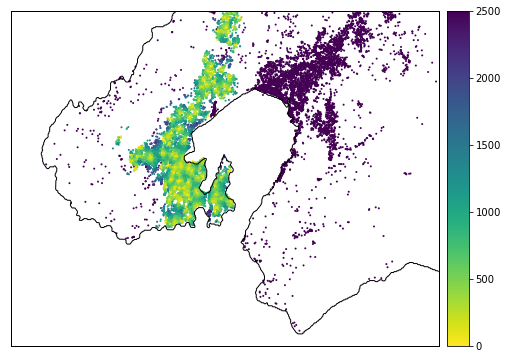

In [23]:
# Plot accessibility
bbox_aspect_ratio = (osm_bbox[2] - osm_bbox[0]) / (osm_bbox[3] - osm_bbox[1])

# Plot accessibility to nearest playground
flat_distance_network.plot(playground_accessibility[1], 
                           osm_bbox, 
                           plot_kwargs={'cmap':'viridis_r','s':4,'edgecolor':'none'},
                           fig_kwargs = {'facecolor':'w', 'figsize':(10, 10 * bbox_aspect_ratio)},
                           bmap_kwargs={'epsg':'2193','resolution':'f'},
                           cbar_kwargs = {'location': 'right'})

### Analyse accessibility
Once the basic analysis is done, we can go as deep as we wish in examining accessibility.
- Plotting the accessibility histogram is a simple thing to start with. 
- Ignoring the far away points (over the 2500m distance threshold) brings the typical distance to a council playgroung to 560 m - very close to the Wellington Council's play spaces planning aims. 

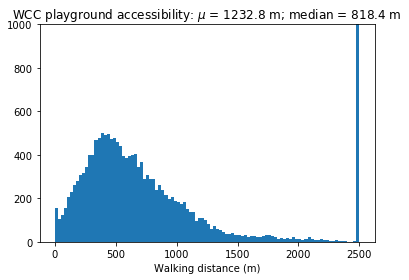

In [24]:
plt.hist(playground_accessibility[1], bins=100);
plt.xlabel('Walking distance (m)');
plt.title("WCC playground accessibility: $\mu$ = {:.1f} m; median = {:.1f} m"
          .format(np.mean(playground_accessibility[1]),
                  np.median(playground_accessibility[1])));
plt.ylim(0, 1000);

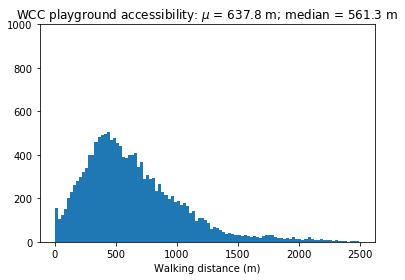

In [25]:
filtered_accessibility = playground_accessibility[1]
filtered_accessibility = filtered_accessibility[filtered_accessibility < 2500]

plt.hist(filtered_accessibility, bins=100);
plt.xlabel('Walking distance (m)');
plt.title("WCC playground accessibility: $\mu$ = {:.1f} m; median = {:.1f} m"
          .format(np.mean(filtered_accessibility),
                  np.median(filtered_accessibility)));
plt.ylim(0, 1000);

### Discussion

- Below are a couple of examples of analysing accessibility by suburb. 
- What other amenities would benefit from accessibility analyses?
- What other analyses are possible with the accessibility output?

| Visualisation | Statistical Analysis |
| :------: | :-----------: | 
|<img src="../assets/karori-accessibility.png" alt="drawing" width="300"/>| <img src="../assets/mean-accessibility-by-suburb.png" alt="drawing" width="300"/> |



## Flows from routes
The very last type of route aggregation we'll do is enriching _existing_ street network edges. Calculations of shortest paths can be aggregated by edge - with edge weight being 'the total number of shortest paths passing through the edge'. While this weight doesn't represent the reality of traffic flow, it's a useful baseline. The design of roads and their connectivity contain enough information for a crude analysis of how people would travel. 

The recipe for calculating expected traffic flow through an urban road network is simple:
- Assign a central location as the destination
- Use the shortest_path algorithm 
    - to route to this destination from every other node in the network
    - this is done by removing the origin argument in the function
- Aggregate the paths and summarise by edge in the network

### Calculate flow

In [26]:
# Create destination 
wgtn_stn = (-41.27803, 174.7811)
wgtn_stn_node = ox.get_nearest_node(G_drive, wgtn_stn)

# Find all driving paths to destination
p = nx.shortest_path(G_drive, target=wgtn_stn_node)
df_p = list(p.values())

In [27]:
# Convert all driving routes to paths in driving road graph
edge_path =  list(map(path_to_edge, df_p, G_drive)) 
stn_paths = [j for i in edge_path for j in i]
count_occurrences = Counter(stn_paths)

# Summarise shortest paths to edges in the network
for u, v, k, data in G_drive.edges(data=True, keys=True):
  data["occurrences"] = count_occurrences[u,v]

### Visualise flow 
To visualise the flow, it's useful to include the Wellington TLA shape. We can get this as a shapefile from external sources or use osmnx to get the shapefile from OpenStreetMap. 

In [29]:
# get the place shape
gdf = ox.gdf_from_place('Wellington City')
gdf = gdf.to_crs({'init': 'epsg:4167'})

![](../assets/wgtn_shape.png)

Like all previous heatmap plots, we have a bunch of boilerplate code to get colours and add a colourbar. The plot also now includes a Polygon patch for the Wellington TLA shapefile. 

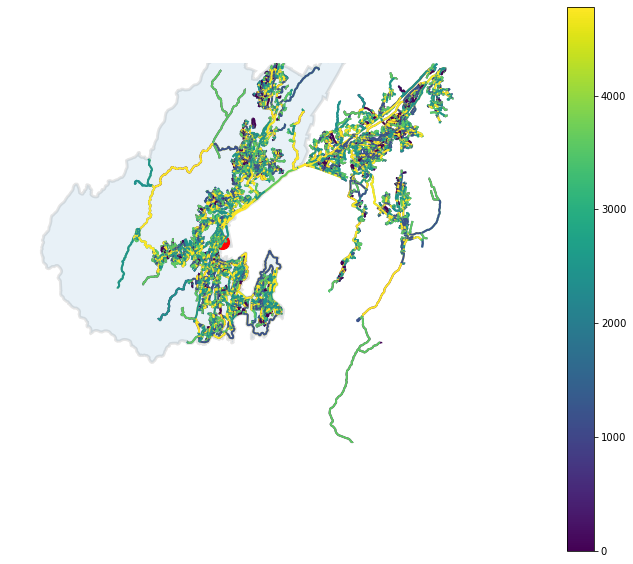

In [30]:
# Plot occurrences on map
G_nodes_flow_df, G_edges_flow_df = ox.graph_to_gdfs(G_drive)
ec = get_edge_colors_by_attr(G_drive, 'occurrences', cmap='viridis')
fig, ax = ox.plot_graph(G_drive, fig_height=10, edge_color= ec, edge_linewidth=2, 
                        node_size=0, show=False, close=False)

# Create colourbar
cmap = mpl.cm.get_cmap('viridis')
normalize = mpl.colors.Normalize(vmin=min(G_edges_flow_df['occurrences']),vmax=max(G_edges_flow_df['occurrences']))

# Add colourbar to axis
cax, _ = mpl.colorbar.make_axes(ax, location='right')
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)

# Add Wellington Station as a point
ax.scatter(wgtn_stn[1], wgtn_stn[0], s=200, c='r')

# Add Wellington City boundary as a polygon patch
wgtn_geometry = gdf['geometry'][0]
patch = PolygonPatch(wgtn_geometry, ec='k', linewidth=3, alpha=0.1, zorder=-1)
ax.add_patch(patch)

# Use Wellington bounding box to set limits
ax.set_xlim(west, east);
ax.set_ylim(south, north);

### Filter to arterial flows
The full heatmap is too cluttered. Let's filter the network to only show arterial roads - those with the highest flows. The 95th percentile of flow is only 43. The flow distribution is very skewed with most nodes in the street network not finding a path to the railway station. 

In [47]:
np.percentile(G_edges_flow_df['occurrences'], 95, axis=0)

43.0

In [48]:
## Filter network according to edge weight percentile
H = nx.MultiDiGraph()
for u,v,attr in G_drive.edges(data=True):
    if attr['occurrences'] >= np.percentile(G_edges_flow_df['occurrences'], 95, axis=0):
        H.add_edge(u,v, occurrences=attr['occurrences'], attr_dict=attr)
        H.nodes[u].update(G_drive.nodes[u])
        H.nodes[v].update(G_drive.nodes[v])
        
# Give some metadata to the new network        
H.graph['crs'] = G_drive.graph['crs']
H.graph['name'] = G_drive.graph['name']

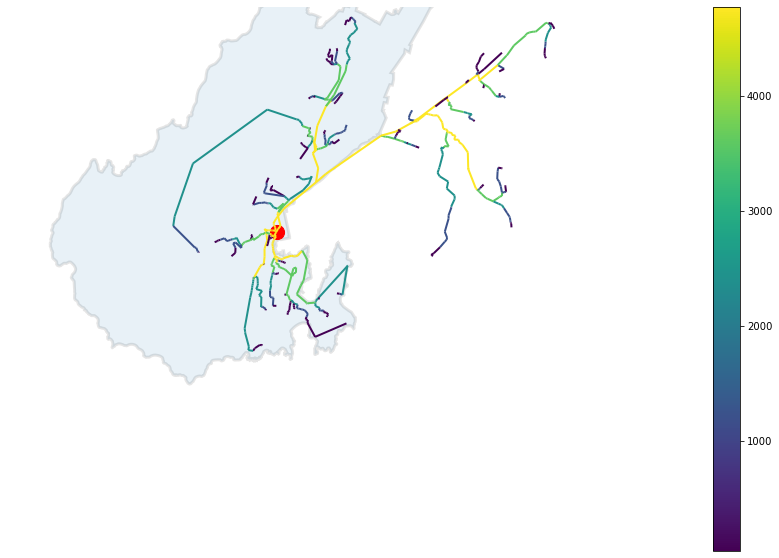

In [49]:
# Plot occurrences on map
H_nodes_flow_df, H_edges_flow_df = ox.graph_to_gdfs(H)
ec = get_edge_colors_by_attr(H, 'occurrences', cmap='viridis')
fig, ax = ox.plot_graph(H, fig_height=10, edge_color= ec, edge_linewidth=2, node_size=0, show=False, close=False)

# Create colourbar
cmap = mpl.cm.get_cmap('viridis')
normalize = mpl.colors.Normalize(vmin=min(H_edges_flow_df['occurrences']),vmax=max(H_edges_flow_df['occurrences']))

# Add colourbar to axis
cax, _ = mpl.colorbar.make_axes(ax, location='right')
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)

# Add Wellington Station as a point
ax.scatter(wgtn_stn[1], wgtn_stn[0], s=200, c='r')

# Add Wellington City boundary as a polygon patch
wgtn_geometry = gdf['geometry'][0]
patch = PolygonPatch(wgtn_geometry, ec='k', linewidth=3, alpha=0.1, zorder=-1)
ax.add_patch(patch)

# Use Wellington bounding box to set limits
ax.set_xlim(west, east);
ax.set_ylim(south, north);

In [50]:
H_edges_flow_df['name'] = H_edges_flow_df['attr_dict'].apply(lambda x: x.get('name'))
H_edges_flow_df.sort_values('occurrences', ascending=False).head()

,u,v,key,occurrences,attr_dict,geometry,name
749,1665398583,1665398586,0,4776,"{'osmid': 153924630, 'oneway': True, 'name': '...","LINESTRING (174.77987 -41.27763, 174.78042 -41...",Mulgrave Street
143,279426875,1665398583,0,4775,"{'osmid': 77078539, 'oneway': True, 'lanes': '...","LINESTRING (174.77989 -41.27703, 174.77987 -41...",Mulgrave Street
142,36161044,279426875,0,4226,"{'osmid': 77078539, 'oneway': True, 'lanes': '...","LINESTRING (174.77979 -41.27551, 174.77989 -41...",Mulgrave Street
664,440626613,36161044,0,4224,"{'osmid': 5184826, 'oneway': True, 'lanes': '2...","LINESTRING (174.77956 -41.27513, 174.77979 -41...",Murphy Street
663,440626612,440626613,0,4222,"{'osmid': 5184826, 'oneway': True, 'lanes': '2...","LINESTRING (174.77897 -41.27415, 174.77956 -41...",Murphy Street


### Discussion
- What other analyses can be done?
- Are there any other ways to generate a useful flow network?

### Homework exercise
- Use the arterial roads network and the [open database of accidents from NZTA's Crash Analysis System (CAS)](https://opendata-nzta.opendata.arcgis.com/datasets/crash-analysis-system-cas-data) to look at the types and frequency of accidents that block the arterial roads. 

In [51]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

